# Reconnaissance des Digits basée sur les enregistrements Audios 

### Importer les bibliothéques necessaires 

In [27]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set(font_scale = 2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 

### Collection du data

In [28]:
from Tools.tools2 import collection

Si jamais on décommente la fonction, l'enregistrement se lance.

In [29]:
#collection()

#### 1. Importer votre DataSet

In [30]:
mydata = pd.read_csv('./DataSet/'+os.listdir('./DataSet/')[0])

##### Print

In [31]:
mydata.head()

,Fe1,Fe2,Fe3,Fe4,Fe5,Fe6,Fe7,Fe8,Fe9,Fe10,Fe11,Fe12,Target
0,14.206059,-16.277263,-3.378399,7.220329,9.838787,-12.330977,2.707890,5.226073,-4.302150,-2.545592,-2.383061,-8.012280,0.0
1,17.551996,-18.415858,4.033585,1.588415,8.236132,-6.529723,0.165237,7.856488,4.199394,1.776879,1.364434,-5.553449,1.0
2,16.694431,-16.252786,-1.179353,5.083449,13.571406,-10.451517,1.434448,10.802134,0.079030,0.053721,0.333923,-8.279302,2.0
3,17.447025,-17.284886,2.074396,3.119711,6.774513,-12.290513,0.332886,9.843150,4.162728,2.272845,-0.771322,-8.002483,3.0
4,16.706861,-18.136654,0.259000,1.277534,6.435347,-9.849664,3.674512,9.351678,1.272110,1.234241,0.356385,-5.576337,4.0


In [32]:
mydata.shape

(50, 13)

#### 2. Checker les variables quantitatives/qualitatives et les valeurs manquantes 

In [33]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe1     50 non-null     float64
 1   Fe2     50 non-null     float64
 2   Fe3     50 non-null     float64
 3   Fe4     50 non-null     float64
 4   Fe5     50 non-null     float64
 5   Fe6     50 non-null     float64
 6   Fe7     50 non-null     float64
 7   Fe8     50 non-null     float64
 8   Fe9     50 non-null     float64
 9   Fe10    50 non-null     float64
 10  Fe11    50 non-null     float64
 11  Fe12    50 non-null     float64
 12  Target  50 non-null     float64
dtypes: float64(13)
memory usage: 5.2 KB


#### 3. Visualiser les targets

In [34]:
mydata["Target"].head()

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
Name: Target, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000258A741A910>]],
      dtype=object)

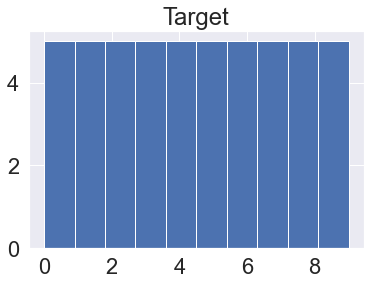

In [35]:
mydata.hist("Target")

#### 4. Notre variable target (Y) est 'gender', Récuprer X et y à partir du jeu de données 

In [36]:
X = mydata.drop('Target', axis=1)
y = mydata['Target'].astype(int)
X.shape

(50, 12)

In [37]:
X.head()

,Fe1,Fe2,Fe3,Fe4,Fe5,Fe6,Fe7,Fe8,Fe9,Fe10,Fe11,Fe12
0,14.206059,-16.277263,-3.378399,7.220329,9.838787,-12.330977,2.707890,5.226073,-4.302150,-2.545592,-2.383061,-8.012280
1,17.551996,-18.415858,4.033585,1.588415,8.236132,-6.529723,0.165237,7.856488,4.199394,1.776879,1.364434,-5.553449
2,16.694431,-16.252786,-1.179353,5.083449,13.571406,-10.451517,1.434448,10.802134,0.079030,0.053721,0.333923,-8.279302
3,17.447025,-17.284886,2.074396,3.119711,6.774513,-12.290513,0.332886,9.843150,4.162728,2.272845,-0.771322,-8.002483
4,16.706861,-18.136654,0.259000,1.277534,6.435347,-9.849664,3.674512,9.351678,1.272110,1.234241,0.356385,-5.576337


In [38]:
y.head()

0    0
1    1
2    2
3    3
4    4
Name: Target, dtype: int32

#### 5. Diviser la DataSet en donneés d'apprentissage et de test (20% pour le test)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 12), (10, 12), (40,), (10,))

#### 6. Recherche du meilleur modèle, avec ses paramètres les plus optimisés, à travers différents pipelines

### Ici on utilise le modèle KNN

In [40]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    
    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to 19 with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])
    leaf_size=trial.suggest_int("leaf_size", 20,40,1)
    p = trial.suggest_int("p", 1,2)

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights, leaf_size=leaf_size, p=p)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y,)
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

[I 2022-03-22 12:58:29,906] A new study created in memory with name: no-name-8684e97c-adda-4091-80b7-5796aa82c7e9
[I 2022-03-22 12:58:29,997] Trial 0 finished with value: 0.76 and parameters: {'scalers': 'standard', 'dim_red': None, 'knn_n_neighbors': 7, 'knn_metric': 'manhattan', 'knn_weights': 'distance', 'leaf_size': 21, 'p': 1}. Best is trial 0 with value: 0.76.
[I 2022-03-22 12:58:30,068] Trial 1 finished with value: 0.8200000000000001 and parameters: {'scalers': 'standard', 'dim_red': None, 'knn_n_neighbors': 3, 'knn_metric': 'manhattan', 'knn_weights': 'distance', 'leaf_size': 22, 'p': 2}. Best is trial 1 with value: 0.8200000000000001.
[I 2022-03-22 12:58:30,127] Trial 2 finished with value: 0.5599999999999999 and parameters: {'scalers': 'minmax', 'dim_red': None, 'knn_n_neighbors': 9, 'knn_metric': 'minkowski', 'knn_weights': 'uniform', 'leaf_size': 39, 'p': 1}. Best is trial 1 with value: 0.8200000000000001.
[I 2022-03-22 12:58:30,189] Trial 3 finished with value: 0.26 and pa

FrozenTrial(number=19, values=[0.8400000000000001], datetime_start=datetime.datetime(2022, 3, 22, 12, 58, 31, 484464), datetime_complete=datetime.datetime(2022, 3, 22, 12, 58, 31, 558461), params={'scalers': 'standard', 'dim_red': None, 'knn_n_neighbors': 3, 'knn_metric': 'minkowski', 'knn_weights': 'uniform', 'leaf_size': 20, 'p': 2}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard')), 'dim_red': CategoricalDistribution(choices=('PCA', None)), 'knn_n_neighbors': IntUniformDistribution(high=19, low=1, step=2), 'knn_metric': CategoricalDistribution(choices=('euclidean', 'manhattan', 'minkowski')), 'knn_weights': CategoricalDistribution(choices=('uniform', 'distance')), 'leaf_size': IntUniformDistribution(high=40, low=20, step=1), 'p': IntUniformDistribution(high=2, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)


Le pipeline nous explique que pour le modèle KNN on peut obtenir une accuracy optimale de 0.84 avec comme hyperparamètres : {'scalers': 'standard', 'dim_red': None, 'knn_n_neighbors': 3, 'knn_metric': 'minkowski', 'knn_weights': 'uniform', 'leaf_size': 20, 'p': 2}

### Ici on utilise le modèle arbre de décision

In [41]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    criterion =trial.suggest_categorical("criterion", ['gini', 'entropy']) 
    max_depth=trial.suggest_int("max depth", 10,160, 1)

    estimator=DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y)
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline



[I 2022-03-22 12:58:38,183] A new study created in memory with name: no-name-3594f3b5-b038-43c7-ad6e-e85baaeef2e3
[I 2022-03-22 12:58:38,289] Trial 0 finished with value: 0.6599999999999999 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 6, 'criterion': 'gini', 'max depth': 159}. Best is trial 0 with value: 0.6599999999999999.
[I 2022-03-22 12:58:38,394] Trial 1 finished with value: 0.6599999999999999 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 6, 'criterion': 'gini', 'max depth': 160}. Best is trial 0 with value: 0.6599999999999999.
[I 2022-03-22 12:58:38,463] Trial 2 finished with value: 0.58 and parameters: {'scalers': 'standard', 'dim_red': None, 'criterion': 'gini', 'max depth': 126}. Best is trial 0 with value: 0.6599999999999999.
[I 2022-03-22 12:58:38,534] Trial 3 finished with value: 0.4999999999999999 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 11, 'criterion': 'gini', 'max depth': 9

FrozenTrial(number=59, values=[0.6799999999999999], datetime_start=datetime.datetime(2022, 3, 22, 12, 58, 42, 637463), datetime_complete=datetime.datetime(2022, 3, 22, 12, 58, 42, 709459), params={'scalers': 'minmax', 'dim_red': None, 'criterion': 'entropy', 'max depth': 160}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard')), 'dim_red': CategoricalDistribution(choices=('PCA', None)), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max depth': IntUniformDistribution(high=160, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=59, state=TrialState.COMPLETE, value=None)


Le pipeline nous explique que pour le modèle arbre de décision on peut obtenir une accuracy optimale de 0.67 avec comme hyperparamètres : {'scalers': 'minmax', 'dim_red': None, 'criterion': 'entropy', 'max depth': 160}

### Ici on utilise le modèle SVM

In [42]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    kernel =trial.suggest_categorical("kernel", ['rbf']) 
    gamma =trial.suggest_int("gamma", 1, 100)
    C = trial.suggest_int("C", 0.1, 1000)

    estimator=SVC(kernel=kernel, gamma=gamma, C=C)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y)
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline



[I 2022-03-22 12:58:45,572] A new study created in memory with name: no-name-ea39eaad-53e5-43dc-ad63-b9062b21a8e4
C:\Users\utilisateur\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0.1, 1000] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 999.1].
  warnings.warn(
[I 2022-03-22 12:58:45,673] Trial 0 finished with value: 0.64 and parameters: {'scalers': 'standard', 'dim_red': None, 'kernel': 'rbf', 'gamma': 65, 'C': 392}. Best is trial 0 with value: 0.64.
C:\Users\utilisateur\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0.1, 1000] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 999.1].
  warnings.warn(
[I 2022-03-22 12:58:45,799] Trial 1 finished with value: 0.4 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 12, 'kernel': 'rbf', 'gamma': 26, 'C': 912}. Best is trial 0 with

FrozenTrial(number=14, values=[0.66], datetime_start=datetime.datetime(2022, 3, 22, 12, 58, 46, 672461), datetime_complete=datetime.datetime(2022, 3, 22, 12, 58, 46, 823466), params={'scalers': 'standard', 'dim_red': None, 'kernel': 'rbf', 'gamma': 69, 'C': 247}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard')), 'dim_red': CategoricalDistribution(choices=('PCA', None)), 'kernel': CategoricalDistribution(choices=('rbf',)), 'gamma': IntUniformDistribution(high=100, low=1, step=1), 'C': IntUniformDistribution(high=999.1, low=0.1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=14, state=TrialState.COMPLETE, value=None)


Le pipeline nous explique que pour le modèle SVM on peut obtenir une accuracy optimale de 0.66 avec comme hyperparamètres : {'scalers': 'standard', 'dim_red': None, 'kernel': 'rbf', 'gamma': 69, 'C': 247}

### Ici on utilise le modèle de forêt aléatoire

In [45]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    max_depth =trial.suggest_int("max_depth", 5, 100) 
    min_samples_leaf =trial.suggest_int("min_samples_leaf", 2, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 25)
    n_estimators = trial.suggest_int("n_estimators", 50, 150)

    estimator=RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y, scoring="accuracy")
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

[I 2022-03-22 13:00:54,623] A new study created in memory with name: no-name-18185acd-2479-4cec-b473-70b2db0936f6
[I 2022-03-22 13:00:56,307] Trial 0 finished with value: 0.6799999999999999 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 11, 'max_depth': 82, 'min_samples_leaf': 9, 'min_samples_split': 23, 'n_estimators': 144}. Best is trial 0 with value: 0.6799999999999999.
[I 2022-03-22 13:00:57,150] Trial 1 finished with value: 0.1 and parameters: {'scalers': 'standard', 'dim_red': None, 'max_depth': 28, 'min_samples_leaf': 19, 'min_samples_split': 3, 'n_estimators': 76}. Best is trial 0 with value: 0.6799999999999999.
[I 2022-03-22 13:00:58,124] Trial 2 finished with value: 0.1 and parameters: {'scalers': 'standard', 'dim_red': None, 'max_depth': 47, 'min_samples_leaf': 16, 'min_samples_split': 23, 'n_estimators': 102}. Best is trial 0 with value: 0.6799999999999999.
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py

FrozenTrial(number=73, values=[0.82], datetime_start=datetime.datetime(2022, 3, 22, 13, 2, 22, 111255), datetime_complete=datetime.datetime(2022, 3, 22, 13, 2, 23, 93292), params={'scalers': 'standard', 'dim_red': None, 'max_depth': 70, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 108}, distributions={'scalers': CategoricalDistribution(choices=('minmax', 'standard')), 'dim_red': CategoricalDistribution(choices=('PCA', None)), 'max_depth': IntUniformDistribution(high=100, low=5, step=1), 'min_samples_leaf': IntUniformDistribution(high=25, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=25, low=2, step=1), 'n_estimators': IntUniformDistribution(high=150, low=50, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=73, state=TrialState.COMPLETE, value=None)


Le pipeline nous explique que pour le modèle de forêt aléatoire on peut obtenir une accuracy optimale de 0.82 avec comme hyperparamètres : {'scalers': 'standard', 'dim_red': None, 'max_depth': 70, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 108}

### Ici on utilise le modèle XGBoost

In [47]:
from xgboost.sklearn import XGBClassifier
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    #scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    #if scalers == "minmax":
     #   scaler = MinMaxScaler()
    #elif scalers == "standard":
     #   scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 0, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    booster =trial.suggest_categorical("booster", ['gbtree', 'dart'])
    eval_metric = trial.suggest_categorical("eval_metric", ['mlogloss'])
    max_depth = trial.suggest_int('max_depth', 3, 10)           
   

    estimator=XGBClassifier(booster=booster, eval_metric=eval_metric, max_depth=max_depth)

    # -- Make a pipeline
    pipeline = make_pipeline(dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X, y, scoring='accuracy')
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline



[I 2022-03-22 13:08:54,813] A new study created in memory with name: no-name-9c52aa06-d682-4f48-9f28-9e3a028e9445
C:\Users\utilisateur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2022-03-22 13:09:02,519] Trial 0 finished with value: 0.5599999999999999 and parameters: {'dim_red': None, 'booster': 'dart', 'eval_metric': 'mlogloss', 'max_depth': 7}. Best is trial 0 with value: 0.5599999999999999.
C:\Users\utilisateur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warnin

FrozenTrial(number=0, values=[0.5599999999999999], datetime_start=datetime.datetime(2022, 3, 22, 13, 8, 54, 816120), datetime_complete=datetime.datetime(2022, 3, 22, 13, 9, 2, 518449), params={'dim_red': None, 'booster': 'dart', 'eval_metric': 'mlogloss', 'max_depth': 7}, distributions={'dim_red': CategoricalDistribution(choices=('PCA', None)), 'booster': CategoricalDistribution(choices=('gbtree', 'dart')), 'eval_metric': CategoricalDistribution(choices=('mlogloss',)), 'max_depth': IntUniformDistribution(high=10, low=3, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


Le pipeline nous explique que pour le modèle XGBoost on peut obtenir une accuracy optimale de 0.55 avec comme hyperparamètres : {'dim_red': None, 'booster': 'dart', 'eval_metric': 'mlogloss', 'max_depth': 7}

## Utilisation du meilleur modèle

In [48]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

classifier = KNeighborsClassifier(n_neighbors= 3, metric= 'minkowski', weights= 'uniform', leaf_size=20, p=2)   
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test,y_predict)

0.8

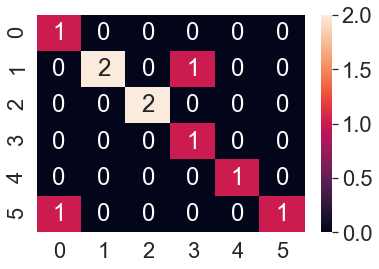

In [49]:
cm = confusion_matrix(y_test, y_predict)
sb.heatmap(cm, annot=True)


# Application en Temps Réel

In [51]:
import joblib
joblib.dump(classifier, 'modele_rfm.pkl')

['modele_rfm.pkl']

In [52]:
import sounddevice as sd #sinon pip install sounddevice
import time #sinon pip install python-time
import scipy.io.wavfile as wav
from python_speech_features import mfcc #sinon pip install python_speech_features==0.4
import wave
import os
import numpy as np
import pandas as pd
import joblib


# Digit Recognition

def rec():

    print("Attention, l'enregistrement commence dans :") 
    for i in range(0,6):
        time.sleep(1)
        print(5-i)
    
    time.sleep(1)
    
    rate = 48000
    duration = 2
           
    

    print("Prononcer votre Digit : ")
    data = sd.rec(int(duration * rate), samplerate=rate, channels=1)
    sd.wait()
        
    data = data / data.max() * np.iinfo(np.int16).max
    data = data.astype(np.int16)
        
    classifier = joblib.load(r"modele_rfm.pkl")
    
    mfcc_feat = np.mean(mfcc(data,rate, numcep=12), axis=0)   
    mfcc_feat = np.expand_dims(mfcc_feat, axis=0)
    pred = classifier.predict(mfcc_feat)
    print('------------------')
    print('Digit : ', pred[0])
    print('------------------')


In [53]:

#rec()

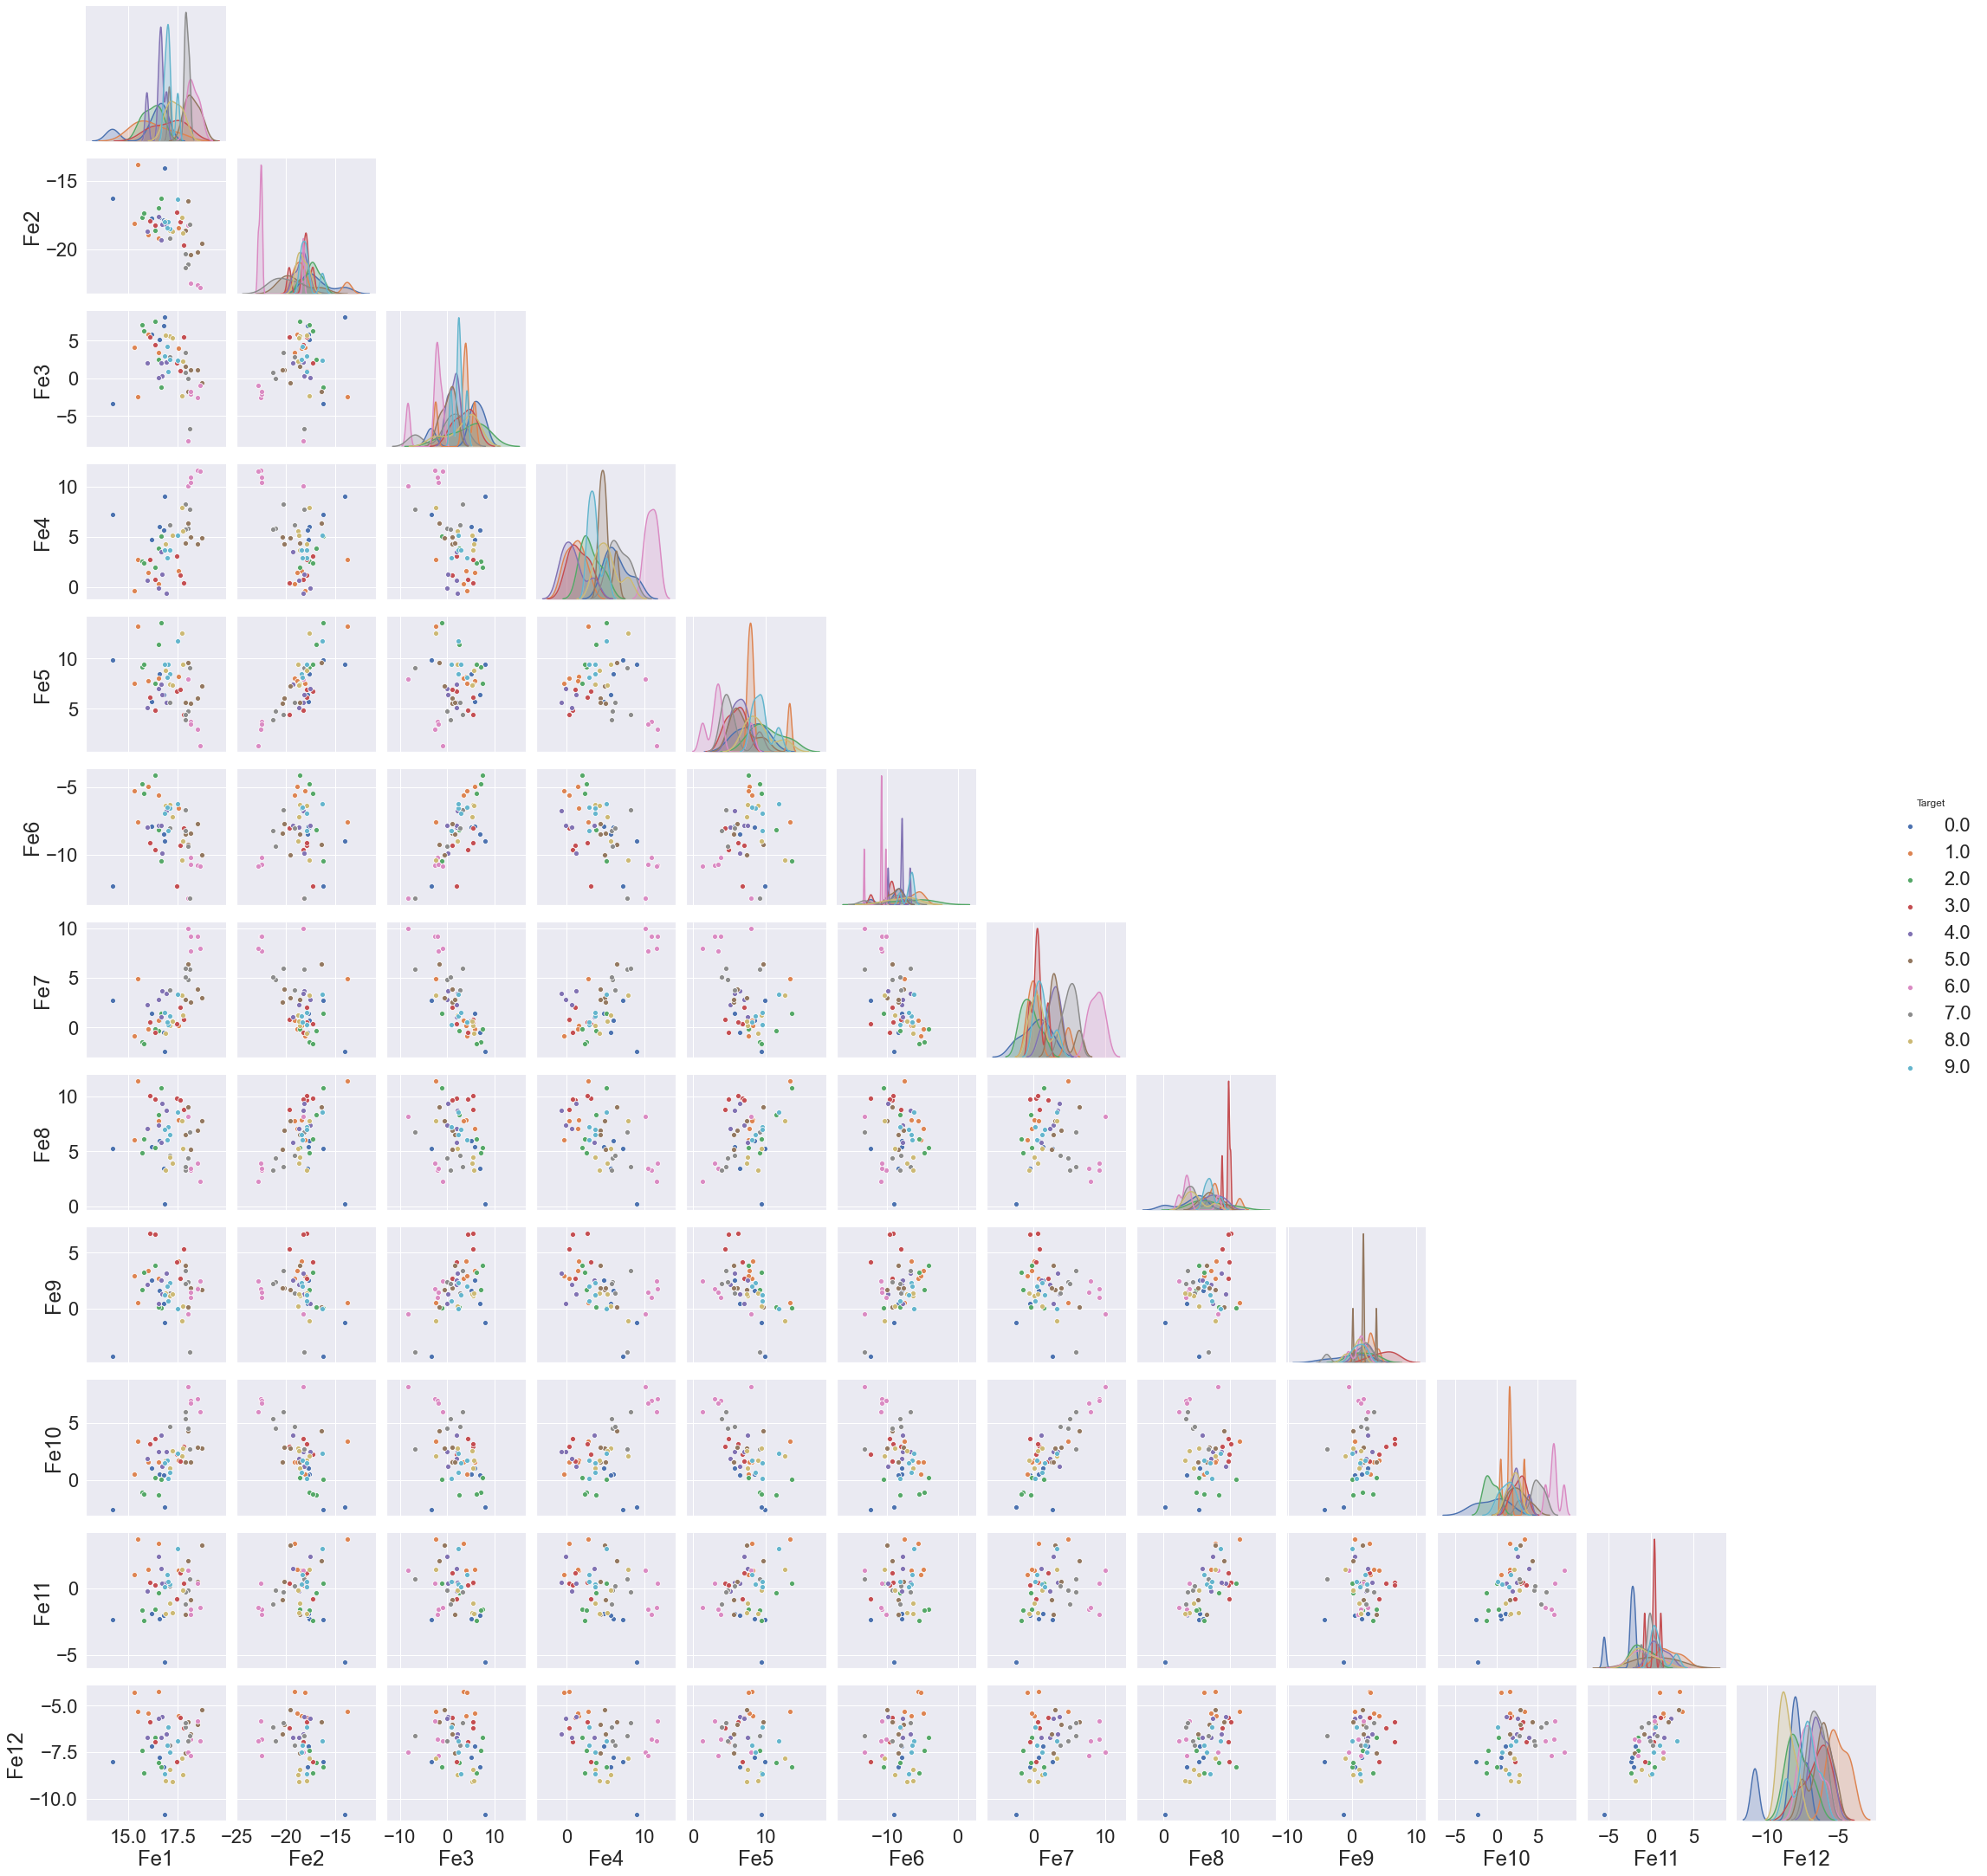

In [54]:
sb.pairplot(mydata, hue="Target", corner = True)

### On décide d'observer la répartition seulement pour les chiffres 0 et 6 (étant donné que sur les graphiques précédents ces deux valeurs étaient bien regroupées entre elles et séparées des autres)

In [55]:
data = []
for i in range(len(mydata)):
    if mydata.loc[i, "Target"] == 0.0 or mydata.loc[i, "Target"] == 6.0 :
        data.append(mydata.loc[i,:])

In [56]:
df = pd.DataFrame(data)
df

,Fe1,Fe2,Fe3,Fe4,Fe5,Fe6,Fe7,Fe8,Fe9,Fe10,Fe11,Fe12,Target
0,14.206059,-16.277263,-3.378399,7.220329,9.838787,-12.330977,2.707890,5.226073,-4.302150,-2.545592,-2.383061,-8.012280,0.0
6,18.526794,-22.601601,-2.525737,11.635982,2.967423,-10.779327,9.157684,3.911211,1.735053,7.107679,0.354585,-5.796975,6.0
10,16.592900,-17.630197,5.110025,6.003398,8.464398,-7.960103,0.730504,5.974185,1.586700,0.514953,-2.273820,-7.797172,0.0
16,18.053412,-18.237011,-8.257290,10.087527,7.998259,-13.238393,9.989735,8.178400,-0.514561,8.208468,1.344825,-7.475692,6.0
20,16.796256,-17.842688,6.923813,5.681668,6.409002,-8.449782,-0.489814,3.475106,0.446553,0.415566,-2.047672,-8.285646,0.0
26,18.164691,-22.434348,-2.082173,10.925298,3.772324,-10.179290,9.147619,3.302362,1.013847,6.980500,-1.955600,-6.778361,6.0
30,16.201137,-17.720926,5.827288,4.734598,5.729265,-7.915077,1.383173,5.403480,2.506809,1.073978,-1.913223,-7.152194,0.0
36,18.173165,-22.495630,-1.770966,10.398685,3.468156,-10.731428,7.683317,3.472781,1.451152,6.698137,-1.593510,-7.694389,6.0
40,16.851610,-14.030036,8.057980,9.050828,9.414047,-8.987277,-2.392695,0.220424,-1.275122,-2.325194,-5.524156,-10.860494,0.0
46,18.672063,-22.799005,-0.951979,11.547419,1.317630,-10.826864,7.987715,2.289379,2.484473,5.953715,-1.437308,-6.905996,6.0


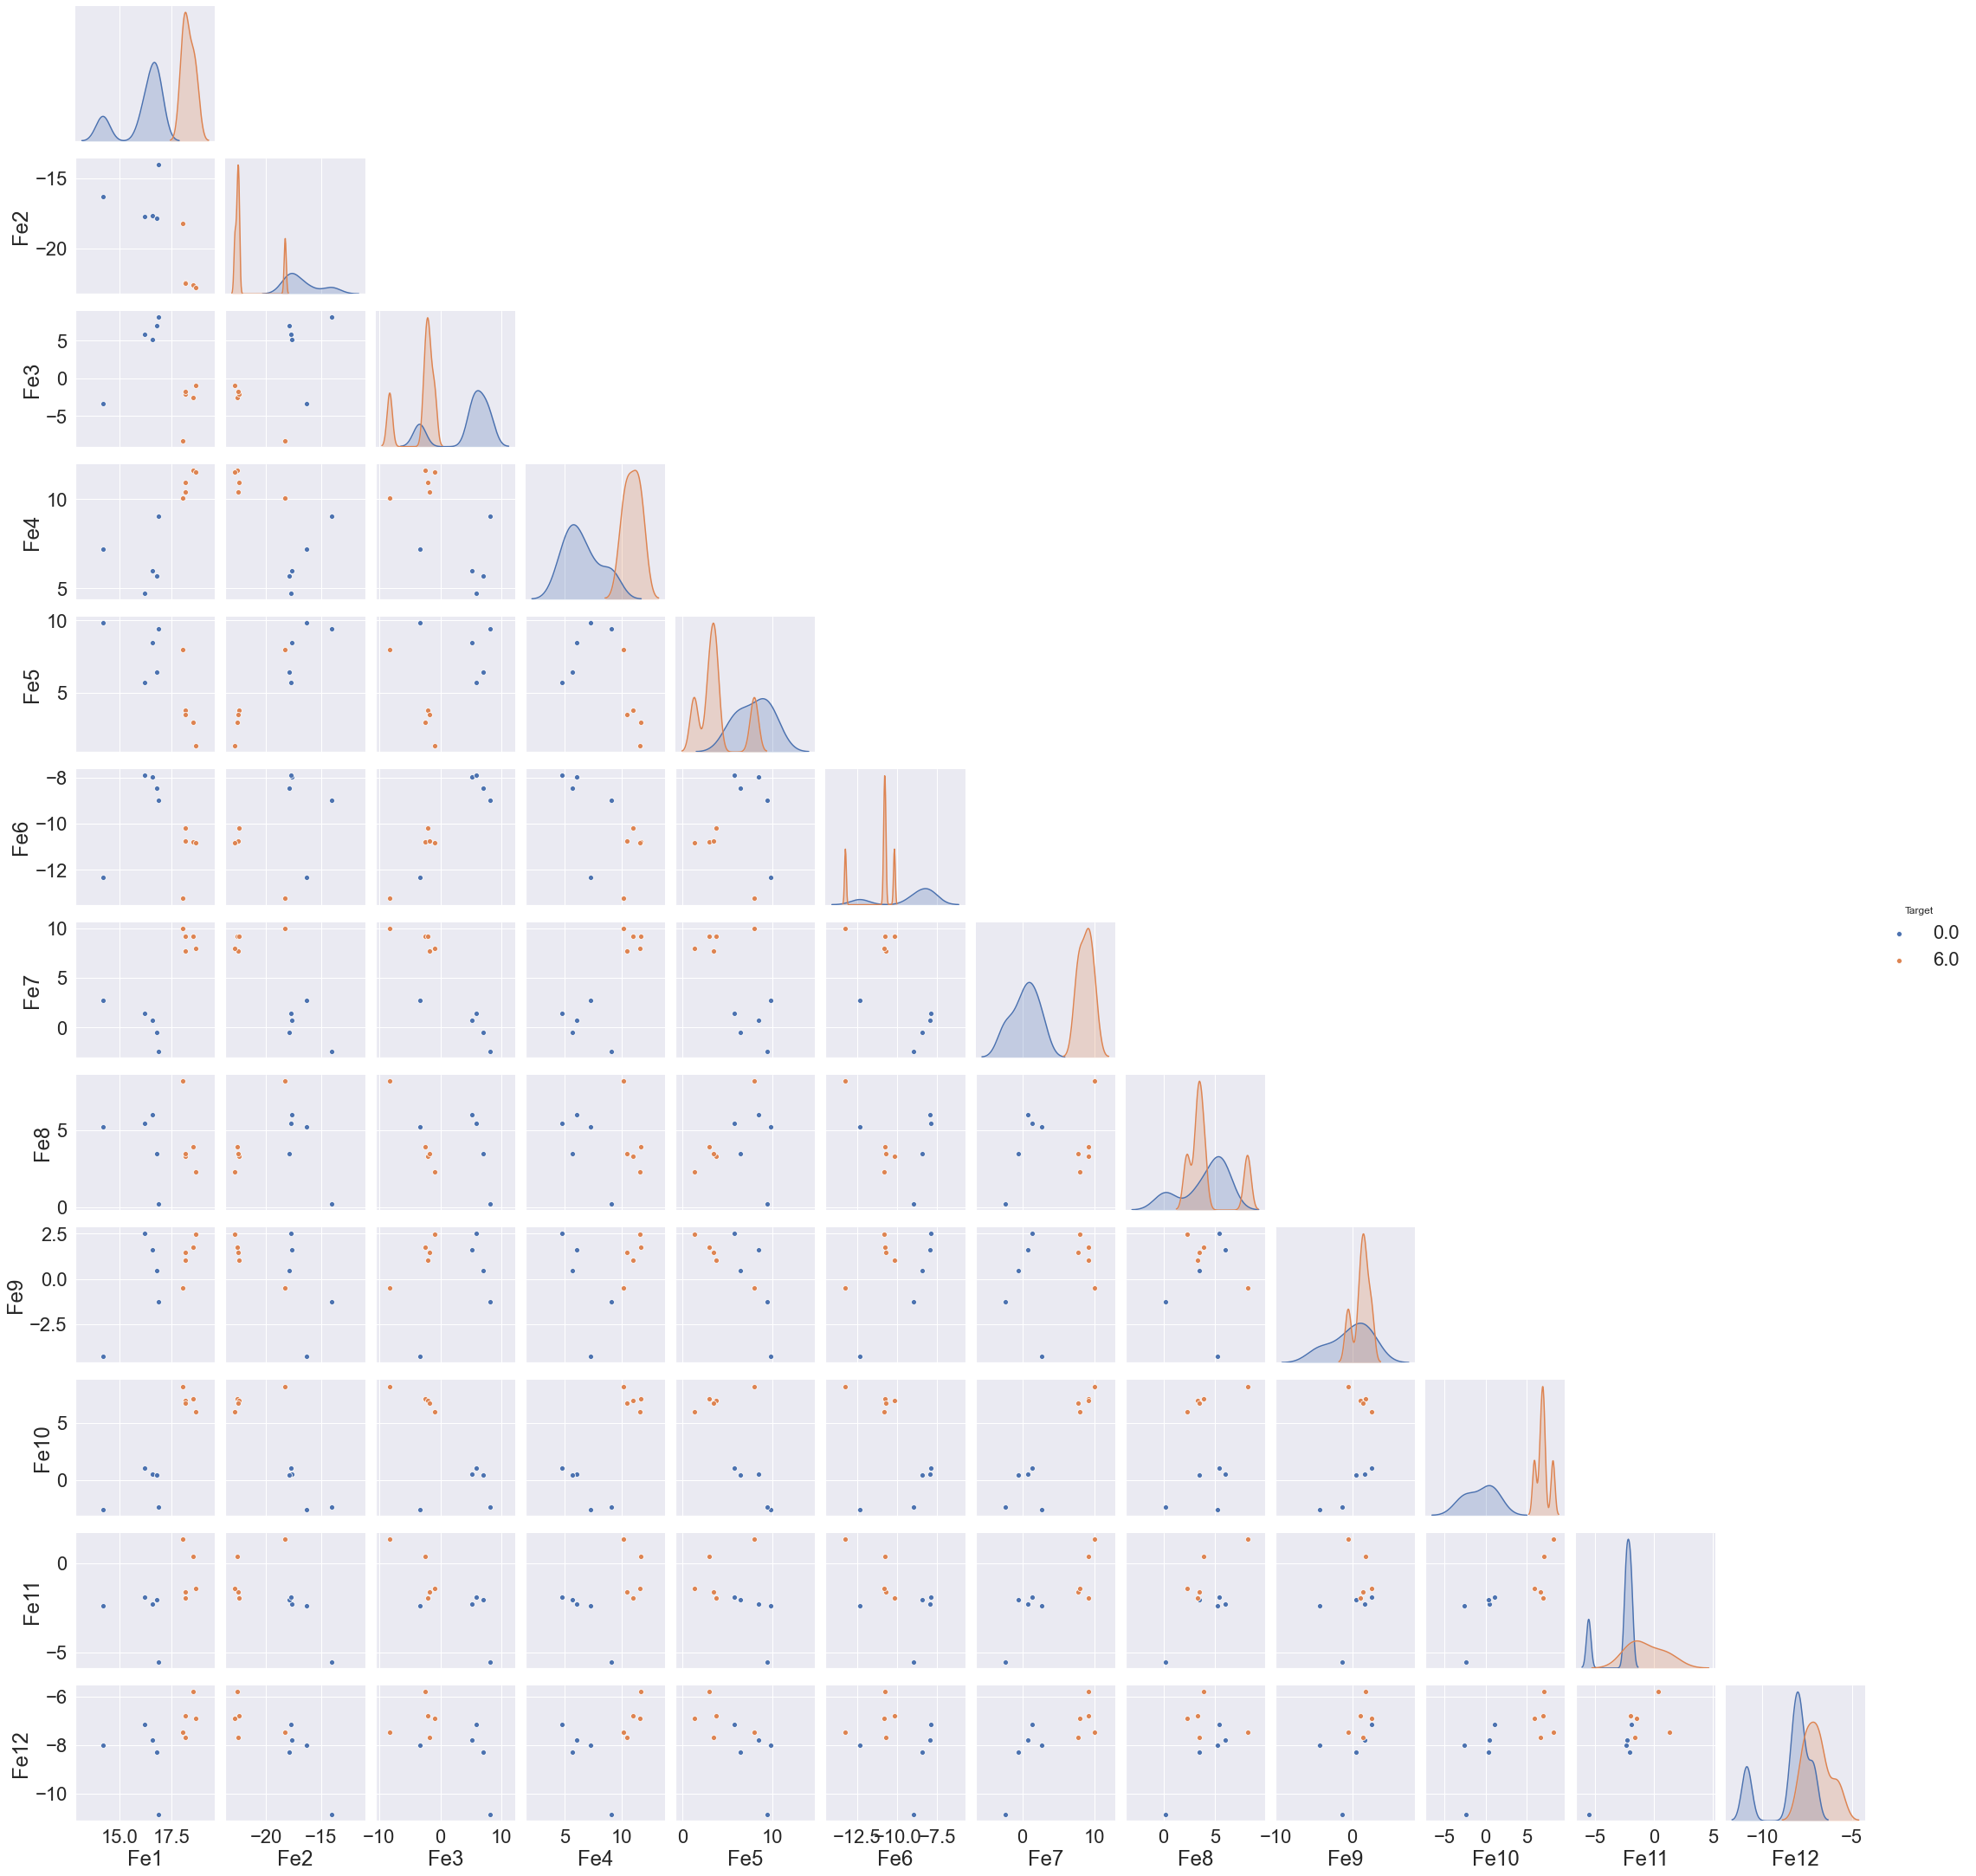

In [57]:
sb.pairplot(df, hue="Target", corner = True)